**Uploading the dataset**

In [1]:
from google.colab import files
files=files.upload()

Saving data_interview_test.csv to data_interview_test.csv


**Installing the required libraries**

In [ ]:
pip install lofo-importance

In [ ]:
pip install optuna

In [4]:
pip install lightgbm

In [ ]:
pip install xgboost

**Importing the required libraries**

In [381]:
import pandas as pd
import numpy as np
import plotly.express as px
import optuna
from lofo import LOFOImportance,Dataset,plot_importance
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score,f1_score,confusion_matrix,roc_curve,precision_recall_curve
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import pickle

In [122]:
test_df=pd.read_csv('/content/data_interview_test.csv',delimiter=':')

**EDA(Exploratory Data Analysis)**

**Checking the data-types for each of the columns**

*   This basically gives us the information about whether the dataset contains numerical/categorical features


*   Here we can see that most of the features are numerical in nature with ids as object or basically string






In [123]:
test_df.dtypes

receipt_id                  object
company_id                   int64
matched_transaction_id      object
feature_transaction_id      object
DateMappingMatch           float64
AmountMappingMatch         float64
DescriptionMatch           float64
DifferentPredictedTime     float64
TimeMappingMatch           float64
PredictedNameMatch         float64
ShortNameMatch             float64
DifferentPredictedDate     float64
PredictedAmountMatch       float64
PredictedTimeCloseMatch    float64
dtype: object

**Percentage of Null Values**

*  Our dataset doesnot contain any null/missing values



In [124]:
(test_df.isnull().sum()/test_df.shape[0])*100

receipt_id                 0.0
company_id                 0.0
matched_transaction_id     0.0
feature_transaction_id     0.0
DateMappingMatch           0.0
AmountMappingMatch         0.0
DescriptionMatch           0.0
DifferentPredictedTime     0.0
TimeMappingMatch           0.0
PredictedNameMatch         0.0
ShortNameMatch             0.0
DifferentPredictedDate     0.0
PredictedAmountMatch       0.0
PredictedTimeCloseMatch    0.0
dtype: float64

In [125]:
test_df.shape

(12034, 14)

In [126]:
test_df.head(2)

,receipt_id,company_id,matched_transaction_id,feature_transaction_id,DateMappingMatch,AmountMappingMatch,DescriptionMatch,DifferentPredictedTime,TimeMappingMatch,PredictedNameMatch,ShortNameMatch,DifferentPredictedDate,PredictedAmountMatch,PredictedTimeCloseMatch
0,"10,000",10000,"10,468","10,000",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,"10,000",10000,"10,468","10,001",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


**Data-Preprocesing**

* Convert the ids related to transaction receipt and company to int dtype



In [127]:
def convert_to_int(df):
  conv_int=int(''.join(df.split(',')))
  return conv_int

In [128]:
test_df['matched_transaction_id']=test_df['matched_transaction_id'].apply(convert_to_int)
test_df['feature_transaction_id']=test_df['feature_transaction_id'].apply(convert_to_int)
test_df['receipt_id']=test_df['receipt_id'].apply(convert_to_int)

**Lets introduce a labels column which will convert this business problem into a ml binary classification problem**

In [129]:
test_df['labels']=[1 if match_trans_id==feat_trans_id else 0 for match_trans_id,feat_trans_id in zip(test_df['matched_transaction_id'].values,test_df['feature_transaction_id'].values)]

**Class Representation**

*   From the below plot we can clearly see that the distribution of matching vs non-matching transaction id is unbalanced

*   The percentage of positive values is about 7% in the entire sample dataset

In [400]:
k_1=test_df[test_df['matched_transaction_id']==test_df['feature_transaction_id']].shape[0]
k_2=test_df[test_df['matched_transaction_id']!=test_df['feature_transaction_id']].shape[0]
comp_df=pd.DataFrame({'transaction_values':['matching','non_matching'],'count_val':[k_1,k_2]})
fig=px.bar(comp_df,x='transaction_values',y='count_val',color='transaction_values',width=700,text_auto=True)
fig.update_layout(title='Comparsion of matching vs non-matching transaction id values')
fig.show()

**Let us analyze the average values for different features for matching vs non-matching transaction ids**

**Observations**

*   The average value for **DateMappingMatch**,**ShortNameMatch**,**PredictedNameMatch**,**PredictedTimeCloseMatch** and **TimeMappingMatch** have significant difference between matching and non-matching transaction id which are labelled as 0 and 1


* **AmountMappingMatch** and **PredictedAmountMatch** have negligible difference between the means for transactions labelled as 0 and 1



In [131]:
def create_plot_df(pass_df,feature_1,feature_2):

  mean_1=np.round(pass_df[pass_df['matched_transaction_id']==pass_df['feature_transaction_id']][feature_1].mean(),2)
  mean_2=np.round(pass_df[pass_df['matched_transaction_id']==pass_df['feature_transaction_id']][feature_2].mean(),2)

  mean_3=np.round(pass_df[pass_df['matched_transaction_id']!=pass_df['feature_transaction_id']][feature_1].mean(),2)
  mean_4=np.round(pass_df[pass_df['matched_transaction_id']!=pass_df['feature_transaction_id']][feature_2].mean(),2)

  comb_df=pd.DataFrame({'match_transaction_values':['{}_transaction_mean'.format(feature_1),'{}_transaction_mean'.format(feature_1),'{}_transaction_mean'.format(feature_2),'{}_transaction_mean'.format(feature_2)],
                        'mean_values':[mean_1,mean_3,mean_2,mean_4],
                        'match_values':['matching_transaction_mean','non_matching_transaction_mean','matching_transaction_mean','non_matching_transaction_mean']})

  return comb_df

In [132]:
my_df=create_plot_df(test_df,'DateMappingMatch','AmountMappingMatch')
fig=px.bar(my_df,color='match_values',y='mean_values',x='match_transaction_values',height=600,color_discrete_sequence=['red'],text_auto=True)
fig.update_layout(title='Comparing the mean values between matching and non-matching transactions',
                  barmode='group')
fig.update_traces(marker_color=['blue','red'])
fig.show()

In [133]:
my_df=create_plot_df(test_df,'DescriptionMatch','DifferentPredictedTime')
fig=px.bar(my_df,color='match_values',y='mean_values',x='match_transaction_values',height=400,color_discrete_sequence=['red'],text_auto=True)
fig.update_layout(title='Comparing the mean values between matching and non-matching transactions',
                  barmode='group')
fig.update_traces(marker_color=['blue','red'])
fig.show()

In [134]:
my_df=create_plot_df(test_df,'TimeMappingMatch','PredictedNameMatch')
fig=px.bar(my_df,color='match_values',y='mean_values',x='match_transaction_values',height=400,color_discrete_sequence=['red'],text_auto=True)
fig.update_layout(title='Comparing the mean values between matching and non-matching transactions',
                  barmode='group')
fig.update_traces(marker_color=['blue','red'])
fig.show()

In [401]:
my_df=create_plot_df(test_df,'ShortNameMatch','DifferentPredictedDate')
fig=px.bar(my_df,color='match_values',y='mean_values',x='match_transaction_values',height=400,color_discrete_sequence=['red'],text_auto=True)
fig.update_layout(title='Comparing the mean values between matching and non-matching transactions',
                  barmode='group')
fig.update_traces(marker_color=['blue','red'])
fig.show()

In [136]:
my_df=create_plot_df(test_df,'PredictedAmountMatch','PredictedTimeCloseMatch')
fig=px.bar(my_df,color='match_values',y='mean_values',x='match_transaction_values',height=400,color_discrete_sequence=['red'],text_auto=True)
fig.update_layout(title='Comparing the mean values between matching and non-matching transactions',
                  barmode='group')
fig.update_traces(marker_color=['blue','red'])
fig.show()

**Let us try to analyze the distribution for some of the features having higher difference in between the mean**

In [88]:
## Box-Plot

**Box-plot Description for DateMappingMatch,ShortNameMatch and DescriptionMatch**

*  Box plot is something which provides us the information about the mean,median upper/lower bound,25th and 75th percentile.it kind of gives us information about the distribution of the dataset for that particular feature

*  If we carefully the observe the distribution of Date Mapping Match for matching vs non-matching transaction values we can clearly see that **transaction values which are basically labelled as 1 have higher values than the rows labelled as 0**.

*  **Now almost 7 to 8 values which belongs to class 1 have very less or almost zero values for Data Mapping match.It can be definitely be a problem from how the dataset is generated and labelled for matching transactions**

*  We can also observe that few observations which are labelled as 0 is having higher values of Date Mapping Match.

*  Now considering the values for **ShortName Match** for both matching and non-matching values we see that the values are either 0 and 1.For **Date Mapping Match** values which are greater than 0 for them also if we check the values for **ShortNameMatch** we can see the values are either 0 and 1


In [137]:
def box_plot_df(feature,pass_df):

  val_1=pass_df[pass_df['matched_transaction_id']==pass_df['feature_transaction_id']][feature].values
  val_2=pass_df[pass_df['matched_transaction_id']!=pass_df['feature_transaction_id']][feature].values

  df_1=pd.DataFrame({'match_values':['matching']*len(val_1),'values':val_1})
  df_2=pd.DataFrame({'match_values':['non_matching']*len(val_2),'values':val_2})
  final_df=pd.concat([df_1,df_2],axis=0)
  return final_df

In [402]:
final_df=box_plot_df('DateMappingMatch',test_df)
fig=px.box(final_df,x='match_values',y='values',title='Box plot comparsion for DateMappingMatch between matching and non-matching transactions')
fig.show()

In [414]:
final_df=box_plot_df('DescriptionMatch',test_df)
fig=px.box(final_df,x='match_values',y='values',title='Box plot comparsion for DescriptionMatch between matching and non-matching transactions')
fig.show()

In [404]:
final_df=box_plot_df('ShortNameMatch',test_df)
fig=px.box(final_df,x='match_values',y='values',title='Box plot comparsion for ShortNameMatch between matching and non-matching transactions')
fig.show()

**Creating the feature list which will be used further for feature selection and training**

In [142]:
features=test_df.columns[4:test_df.shape[1]-1].tolist()

**Correlation plot**

*  From the correlation plot we can clearly see that (**DateMappingMatch**,**DifferentPredicteddate**) and (**TimeMappingMatch**,**DifferentPredictedTime**) are highly negative correlated with each other



In [143]:
corr_values=test_df[features].corr()
corr_values.style.background_gradient(cmap='Blues_r').set_precision(2)

,DateMappingMatch,AmountMappingMatch,DescriptionMatch,DifferentPredictedTime,TimeMappingMatch,PredictedNameMatch,ShortNameMatch,DifferentPredictedDate,PredictedAmountMatch,PredictedTimeCloseMatch
DateMappingMatch,1.00,-0.01,0.15,-0.19,0.19,0.18,0.20,-0.99,0.02,0.16
AmountMappingMatch,-0.01,1.00,-0.01,-0.01,0.01,-0.03,0.03,0.01,0.29,0.02
DescriptionMatch,0.15,-0.01,1.00,-0.09,0.09,0.27,0.10,-0.15,0.00,0.08
DifferentPredictedTime,-0.19,-0.01,-0.09,1.00,-0.99,-0.13,-0.16,0.18,0.01,-0.41
TimeMappingMatch,0.19,0.01,0.09,-0.99,1.00,0.13,0.16,-0.18,-0.01,0.40
PredictedNameMatch,0.18,-0.03,0.27,-0.13,0.13,1.00,0.40,-0.17,-0.01,0.08
ShortNameMatch,0.20,0.03,0.10,-0.16,0.16,0.40,1.00,-0.19,0.02,0.07
DifferentPredictedDate,-0.99,0.01,-0.15,0.18,-0.18,-0.17,-0.19,1.00,-0.02,-0.15
PredictedAmountMatch,0.02,0.29,0.00,0.01,-0.01,-0.01,0.02,-0.02,1.00,0.04
PredictedTimeCloseMatch,0.16,0.02,0.08,-0.41,0.40,0.08,0.07,-0.15,0.04,1.00


**Normalizing the data**

*  Here as the features are not having normal distribution we will be going with **Min-Max Scaler**



In [144]:
for feat_name in features:
    test_df[feat_name]=MinMaxScaler().fit_transform(test_df[feat_name].values.reshape(-1,1))

**Feature Selection**

*   Here feature selection is performed before putting all the features into the model as some features might be redundant and do not add much in the overall contribution towars classifying a transaction

*   As we already observed there is **high negative correlation between two pairs of features**

*   **Leave One feature Out** method is used for selecting the features which generally uses a cv scheme to find out the overall score for the performance metric which is provided

*   Two base models are used for selecting the features which are **Logistic_regression** and **XGB-Classifier**

In [145]:
def get_lofo_importance(target,model):
  if model=='Logistic_Regression':
    features=test_df.columns[4:test_df.shape[1]-1].tolist()
    cv=KFold(n_splits=3,shuffle=True,random_state=42)
    dataset=Dataset(df=test_df,target=target,features=features)
    model=LogisticRegression(random_state=42)
    lofo_imp=LOFOImportance(dataset,scoring='f1',model=model,cv=cv,n_jobs=-1)
    importance_df=lofo_imp.get_importance()
    return importance_df
  
  if model=='XGBClassifier':
    features=test_df.columns[4:test_df.shape[1]-1].tolist()
    cv=KFold(n_splits=3,shuffle=True,random_state=42)
    dataset=Dataset(df=test_df,target=target,features=features)
    model=XGBClassifier(random_state=42)
    lofo_imp=LOFOImportance(dataset,scoring='f1',model=model,cv=cv,n_jobs=-1)
    importance_df=lofo_imp.get_importance()
    return importance_df



**Understanding the feature selection process**

*   The benefit of using this feature selection technique it not only uses a cv scheme for validation of the metric scores also provides us with nscores which negatively affects the performnce metric upon inclusion



  0%|          | 0/10 [00:00<?, ?it/s]

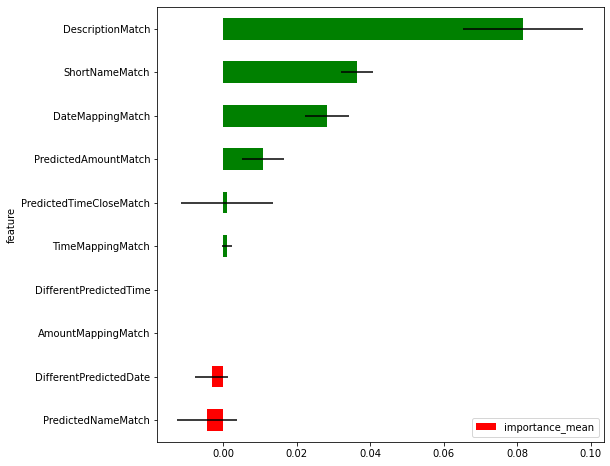

In [147]:
plot_importance(get_lofo_importance('labels','Logistic_Regression'),figsize=(8,8))

**Splitting the values into train and test**

*  Here we are using **Stratified Smpling** which will maintain the same ratio for both positive and negative classes in both train and test samples



In [148]:
y=test_df['labels'].values
X=test_df.drop('labels',axis=1)
X_tr,X_te,y_tr,y_te=train_test_split(X,y,test_size=0.2,random_state=42,shuffle=True,stratify=y)

**Dropping the features which are negatively affecting the performnce metric score(F1-Score) and removing one of the features which is highly correlated with the other one based upon the importance mean scores**

In [205]:
features=test_df.columns[4:test_df.shape[1]-1].tolist()
features.remove('PredictedNameMatch')
features.remove('DifferentPredictedDate')
features.remove('DifferentPredictedTime')

**Hyperparametr Tuning**

*  **Hyperparameter Tuning** is performed using **optuna**
which uses a probabilistic approach to evaluate the hyperparams by building a surrogate of the objective function



**Logistic Regression**

In [206]:
def objective(trial):
    inv_reg_param=trial.suggest_uniform('C',1,50)
    clf=LogisticRegression(C=inv_reg_param)
    score=cross_val_score(clf,X_tr[features],y_tr,scoring='f1',cv=5,n_jobs=-1)
    f_score=score.mean()

    return f_score

In [207]:
study=optuna.create_study(direction='maximize')
study.optimize(objective,n_trials=30)

[I 2022-07-10 05:03:13,959] A new study created in memory with name: no-name-848dd04e-e179-4a6f-9371-82d4a174a991
[I 2022-07-10 05:03:14,445] Trial 0 finished with value: 0.6327019373899259 and parameters: {'C': 26.678995186319657}. Best is trial 0 with value: 0.6327019373899259.
[I 2022-07-10 05:03:14,646] Trial 1 finished with value: 0.6327019373899259 and parameters: {'C': 29.163491723764857}. Best is trial 0 with value: 0.6327019373899259.
[I 2022-07-10 05:03:14,835] Trial 2 finished with value: 0.6327019373899259 and parameters: {'C': 35.47565648611581}. Best is trial 0 with value: 0.6327019373899259.
[I 2022-07-10 05:03:15,028] Trial 3 finished with value: 0.6327019373899259 and parameters: {'C': 6.04945141680618}. Best is trial 0 with value: 0.6327019373899259.
[I 2022-07-10 05:03:15,221] Trial 4 finished with value: 0.6327019373899259 and parameters: {'C': 47.01876552782324}. Best is trial 0 with value: 0.6327019373899259.
[I 2022-07-10 05:03:15,419] Trial 5 finished with value

In [208]:
trial=study.best_trial

In [209]:
trial.value

0.6335837200078792

In [210]:
trial.params

{'C': 1.4374594161160728}

In [211]:
log_cls_modified=LogisticRegression(C=1.437)
log_cls_modified.fit(X_tr[features],y_tr)

LogisticRegression(C=1.437)

In [418]:
file=open('log_cls.txt','wb')
pickle.dump(log_cls_modified,file)
file.close()

In [212]:
y_pred_valid_log_reg_prob=log_cls_modified.predict_proba(X_te[features])[:,1]

In [213]:
y_pred_valid_log_reg=log_cls_modified.predict(X_te[features])

**Evaluating our model on the validation set**

*  Here we are checking both F1-Score and Auc Score for evaluating our models

* F1-Score is coming about 0.67 with auc score as 0.89



In [214]:
print('F1 Score is ',np.round(f1_score(y_pred_valid_log_reg,y_te),2))

F1 Score is  0.67


In [405]:
print('Roc Auc Score is ',np.round(roc_auc_score(y_pred_valid_log_reg,y_te),2))

Roc Auc Score is  0.89


In [216]:
prec,rec,thresholds=precision_recall_curve(y_te,y_pred_valid_log_reg_prob)

In [217]:
f_scores=[(2*pr*re)/(pr+re) for pr,re in zip(prec,rec)]

In [218]:
best_f_score=f_scores[np.argmax(f_scores)]
np.round(best_f_score,2)

0.67

**Confusion Matrix**

*   Confusion Matrix gives us  avery clear representation of how our model is behaving on unseen data

*  If we look a the **Precision--->82% which indicates the fact that whnever we are predicted something of positive class we are correct 82% of the times**

*  If we look at the **Recall----> 56% ehich indicates the fact that out of total 171 data points which belongs to positive class we are only able to predict 96 points belonging to that class and rest points have been miscalssifies as ngative class**

* The ** primary reason of recall to be lower is due to the class imbalance as we need some solid enggineered features which can help us differentiate the positve from negative to a greater extent**







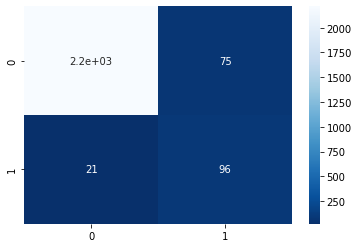

In [406]:
cm_mat=confusion_matrix(y_pred_valid_log_reg,y_te)
sns.heatmap(cm_mat,annot=True,cmap='Blues_r')
plt.show()

**XGBClassifer**

In [ ]:
# XGBClassifier

**Feature Importance with base model as XgbClassifier**

  0%|          | 0/10 [00:00<?, ?it/s]

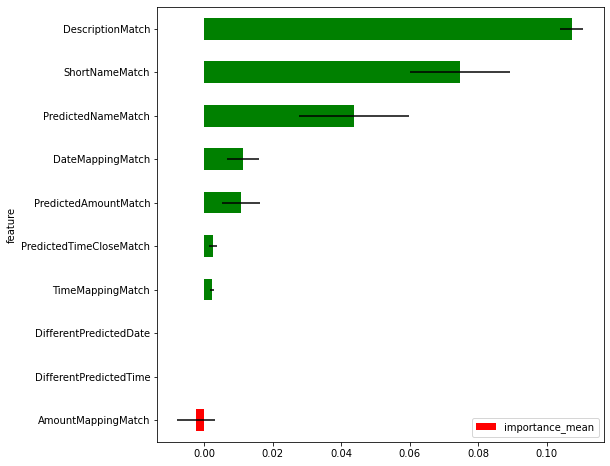

In [204]:
plot_importance(get_lofo_importance('labels','XGBClassifier'),figsize=(8,8))

**Removing the redundant and high correlated features**

In [230]:
features=test_df.columns[4:test_df.shape[1]-1].tolist()
features.remove('DifferentPredictedTime')
features.remove('AmountMappingMatch')

**Hyperparametr Tuning**

* Parametrs tuned are

**Max Depth**

**Number-Estimators**

**Subsample(Row-Sampling)**



In [320]:
def objective(trial):
  max_depth=int(trial.suggest_discrete_uniform('max_depth',3,10,1))
  n_estimators=int(trial.suggest_discrete_uniform('n_estimators',300,500,20))
  subsample=trial.suggest_uniform('subsample',0.6,0.9)
  clf=XGBClassifier(max_depth=max_depth,n_estimators=n_estimators,subsample=subsample)
  score=cross_val_score(clf,X_tr[features],y_tr,scoring='f1',cv=5,n_jobs=-1)
  f_score=score.mean()

  return f_score

In [321]:
study=optuna.create_study(direction='maximize')
study.optimize(objective,n_trials=10)

[I 2022-07-10 06:32:10,140] A new study created in memory with name: no-name-ae33d865-79cb-4d38-ba99-abbefe0a9674
[I 2022-07-10 06:32:17,782] Trial 0 finished with value: 0.6896105845904664 and parameters: {'max_depth': 3.0, 'n_estimators': 360.0, 'subsample': 0.7858544573769084}. Best is trial 0 with value: 0.6896105845904664.
[I 2022-07-10 06:32:31,119] Trial 1 finished with value: 0.6869182461230272 and parameters: {'max_depth': 9.0, 'n_estimators': 460.0, 'subsample': 0.8038459944885299}. Best is trial 0 with value: 0.6896105845904664.
[I 2022-07-10 06:32:39,713] Trial 2 finished with value: 0.6867239056980575 and parameters: {'max_depth': 4.0, 'n_estimators': 480.0, 'subsample': 0.7636550808495609}. Best is trial 0 with value: 0.6896105845904664.
[I 2022-07-10 06:32:48,248] Trial 3 finished with value: 0.6863892421776641 and parameters: {'max_depth': 8.0, 'n_estimators': 300.0, 'subsample': 0.6601312260308864}. Best is trial 0 with value: 0.6896105845904664.
[I 2022-07-10 06:32:58

In [324]:
trial=study.best_trial

In [325]:
trial.value

0.6916930326434187

**Best Params**

In [326]:
trial.params

{'max_depth': 9.0, 'n_estimators': 340.0, 'subsample': 0.6007275316939101}

In [327]:
xgb_cls_modified=XGBClassifier(max_depth=9,n_estimators=340,subsample=0.6)
xgb_cls_modified.fit(X_tr[features],y_tr)

XGBClassifier(max_depth=9, n_estimators=340, subsample=0.6)

**Improved Score**

*   By using XGBClassifer f1-score and auc score has improved as opposed to using Logistic regression

*   **F1-Score-->0.69 and Auc -Score--->0.92**



In [415]:
y_pred_valid_xgb_cls=xgb_cls_modified.predict(X_te[features])
print('F1 score is',np.round(f1_score(y_pred_valid_xgb_cls,y_te),2))
print('Roc Auc  score is',np.round(roc_auc_score(y_pred_valid_xgb_cls,y_te),2))

F1 score is 0.69
Roc Auc  score is 0.92


**Confusion Matrix**

*   If we look at the **Precision-->87% which indicates the fact that 87% of the times when we are predicting a transaction to be of positive class it belongs to that which also results into an improves auc score**

*   For **Recall-->57% there is not much improvement as still we are not able to classify all the positive class values to a greater extent**



[[2221   73]
 [  15   98]]


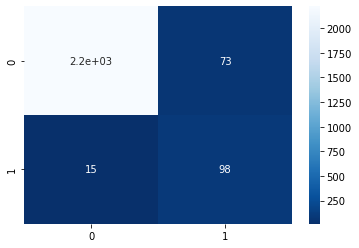

In [408]:
cm_mat=confusion_matrix(y_pred_valid_xgb_cls,y_te)
print(cm_mat)
sns.heatmap(cm_mat,annot=True,cmap='Blues_r')
plt.show()

**Saving xgboost  model as pickle file as it has the best f1 and auc score**

In [384]:
file=open('xgb_cls.txt','wb')
pickle.dump(xgb_cls_modified,file)
file.close()

**LightGBM Classifier**

In [251]:
##### LGBM Classifier

**Parameters which are tuned**

* **Max-Depth**

* **Learning-Rate**

* **N_Estimators**

In [338]:
def objective(trial):
  max_depth=int(trial.suggest_discrete_uniform('max_depth',3,10,1))
  n_estimators=int(trial.suggest_discrete_uniform('n_estimators',300,1000,50))
  learning_rate=trial.suggest_loguniform('learning_rate',0.01,0.1)
  clf=LGBMClassifier(max_depth=max_depth,n_estimators=n_estimators,learning_rate=learning_rate)
  score=cross_val_score(clf,X_tr[features],y_tr,scoring='f1',cv=5,n_jobs=-1)
  f_score=score.mean()

  return f_score

In [339]:
study=optuna.create_study(direction='maximize')
study.optimize(objective,n_trials=15)

[I 2022-07-10 06:38:13,928] A new study created in memory with name: no-name-e5475a18-794c-4421-bcb7-d76e6a65a2fb
[I 2022-07-10 06:38:17,391] Trial 0 finished with value: 0.6879743889900012 and parameters: {'max_depth': 5.0, 'n_estimators': 1000.0, 'learning_rate': 0.05799777421824531}. Best is trial 0 with value: 0.6879743889900012.
[I 2022-07-10 06:38:19,355] Trial 1 finished with value: 0.6869466129055248 and parameters: {'max_depth': 7.0, 'n_estimators': 500.0, 'learning_rate': 0.06289128991412217}. Best is trial 0 with value: 0.6879743889900012.
[I 2022-07-10 06:38:21,234] Trial 2 finished with value: 0.6925001601393853 and parameters: {'max_depth': 3.0, 'n_estimators': 800.0, 'learning_rate': 0.010279634465202121}. Best is trial 2 with value: 0.6925001601393853.
[I 2022-07-10 06:38:23,139] Trial 3 finished with value: 0.6879243118094293 and parameters: {'max_depth': 5.0, 'n_estimators': 600.0, 'learning_rate': 0.06061930852514062}. Best is trial 2 with value: 0.6925001601393853.


In [340]:
trial=study.best_trial

**Best Params**

In [341]:
trial.params

{'learning_rate': 0.010608435884455638,
 'max_depth': 3.0,
 'n_estimators': 900.0}

In [342]:
trial.value

0.6947647948068115

In [343]:
lgb_cls_modified=LGBMClassifier(max_depth=3,n_estimators=900,learning_rate=0.0106)
lgb_cls_modified.fit(X_tr[features],y_tr)

LGBMClassifier(learning_rate=0.0106, max_depth=3, n_estimators=900)

In [416]:
file=open('lgb_cls.txt','wb')
pickle.dump(lgb_cls_modified,file)
file.close()

In [344]:
y_pred_valid_lgb_cls=lgb_cls_modified.predict(X_te[features])
print('F1 score is',np.round(f1_score(y_pred_valid_lgb_cls,y_te),2))
print('Roc Auc  score is',np.round(roc_auc_score(y_pred_valid_lgb_cls,y_te),2))

F1 score is 0.69
Roc Auc  score is 0.89


**Confusion Matrix**

*   **Precision--> Precison has reduced as compared to Xgboost and Log-Reg model and is coming out to be 81.6% which indicates the fact out of 100 times only 81 % of the times we are able to classify transaction into positive class**

*   **Recall--> Recall has improved a little from 56 to 59% as lesser points are classified as negative class from this model**



[[2213   69]
 [  23  102]]


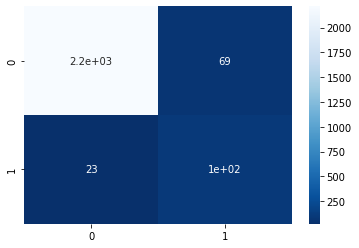

In [412]:
cm_mat=confusion_matrix(y_pred_valid_lgb_cls,y_te)
print(cm_mat)
sns.heatmap(cm_mat,annot=True,cmap='Blues_r')
plt.show()

**Random-Forest Classifer**

In [305]:
## RandomForest Classifier

**Parameters which are tuned**

*  **Max-Depth**

*  **N_Estimators**



In [367]:
def objective(trial):
  max_depth=int(trial.suggest_discrete_uniform('max_depth',10,20,1))
  n_estimators=int(trial.suggest_discrete_uniform('n_estimators',300,500,20))
  #n_estimators=int(trial.suggest_discrete_uniform('n_estimators',300,1000,50))
  clf=RandomForestClassifier(max_depth=max_depth,n_estimators=n_estimators)
  score=cross_val_score(clf,X_tr[features],y_tr,scoring='f1',cv=5,n_jobs=-1)
  f_score=score.mean()

  return f_score

In [368]:
study=optuna.create_study(direction='maximize')
study.optimize(objective,n_trials=10)

[I 2022-07-10 06:49:24,164] A new study created in memory with name: no-name-8082a434-5885-4d15-ac6f-f0f0d75e0f96
[I 2022-07-10 06:49:30,967] Trial 0 finished with value: 0.6898490089496537 and parameters: {'max_depth': 20.0, 'n_estimators': 500.0}. Best is trial 0 with value: 0.6898490089496537.
[I 2022-07-10 06:49:35,561] Trial 1 finished with value: 0.6904606431234773 and parameters: {'max_depth': 10.0, 'n_estimators': 380.0}. Best is trial 1 with value: 0.6904606431234773.
[I 2022-07-10 06:49:40,786] Trial 2 finished with value: 0.68604828326416 and parameters: {'max_depth': 10.0, 'n_estimators': 440.0}. Best is trial 1 with value: 0.6904606431234773.
[I 2022-07-10 06:49:46,143] Trial 3 finished with value: 0.68604828326416 and parameters: {'max_depth': 10.0, 'n_estimators': 460.0}. Best is trial 1 with value: 0.6904606431234773.
[I 2022-07-10 06:49:51,653] Trial 4 finished with value: 0.6842960702790704 and parameters: {'max_depth': 12.0, 'n_estimators': 460.0}. Best is trial 1 wi

In [369]:
trial=study.best_trial

**Best Params**

In [370]:
trial.params

{'max_depth': 10.0, 'n_estimators': 380.0}

In [371]:
trial.value

0.6904606431234773

In [372]:
rf_cls_modified=RandomForestClassifier(max_depth=10,n_estimators=380)
rf_cls_modified.fit(X_tr[features],y_tr)

RandomForestClassifier(max_depth=10, n_estimators=380)

In [417]:
file=open('rf_cls.txt','wb')
pickle.dump(rf_cls_modified,file)
file.close()

In [373]:
y_pred_valid_rf_cls=rf_cls_modified.predict(X_te[features])
print('F1 score is',np.round(f1_score(y_pred_valid_rf_cls,y_te),2))
print('Roc Auc  score is',np.round(roc_auc_score(y_pred_valid_rf_cls,y_te),2))

F1 score is 0.68
Roc Auc  score is 0.92


**Confusion Matrix**

* **Precision is coming to be 87% which is the same as Xgboost**

*   **Recall is coming out to be 56% which is slightly lower than xgboost**



[[2222   75]
 [  14   96]]


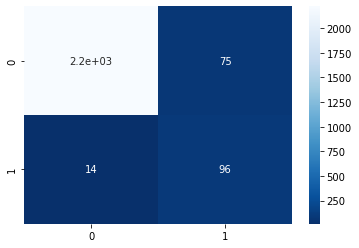

In [409]:
cm_mat=confusion_matrix(y_pred_valid_rf_cls,y_te)
print(cm_mat)
sns.heatmap(cm_mat,annot=True,cmap='Blues_r')
plt.show()

In [ ]:
********************************** END OF NOTEBOOK **********************************